In [1]:
import numpy as np
from dataclasses import dataclass


In [2]:
dt = 0.05
FF = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64)

Pnn0 = np.identity(4, dtype=np.float64)

qa = np.sqrt(10)
Qa = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64) * qa
QQ = FF @ Qa @ FF.T

HH = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], dtype=np.float64)

vn = np.array([np.sqrt(10), np.sqrt(10)], dtype=np.float64)[:, np.newaxis]
Rn = vn @ vn.T

@dataclass
class xylist:
    sources: np.ndarray
    
    def __post_init__(self):
        
        self.sortedSources = self.sources[self.sources[:,2].argsort()[::-1]] # sort by flux
    
    def topNsources(self, numSources):
        return self.sortedSources[0:numSources, :]

In [3]:
with open("xyIms.dat", 'rb') as ff:
    xyIms = np.load(ff, allow_pickle=True)

In [46]:
# print(xyIms[0].sources[0:10, 0:2])
def source2colvec(sourceArray):

    nS = len(sourceArray.flat)
    stateVec = np.zeros((nS), dtype=np.float64)[:, np.newaxis]
    for idx, xx in enumerate(sourceArray.flat):
        stateVec[idx, 0] = xx
    
    return stateVec

def makeFFmatrix(sourceArray, velArray, dt):
    
    numSources = sourceArray.shape[0]
    numVels = sourceArray.shape[0]
    
    fShape = numSources * 2 + 2
    FF = np.identity(fShape, dtype=np.float64)
    
    # dtIdx = (0, fShape-1)
    for idx in range(numSources*2):
        FF[idx, -2 + (idx % 2)] = dt
        # FF[dtIdx[0], dtIdx[1]] = dt
        # dtIdx = [vv + 1 for vv in dtIdx]
        # print(FF[0, 2])
    
    return FF

def makeHHmatrix(numSources):
    
    HH = np.identity(numSources*2, dtype=np.float64)
    zc = np.zeros((numSources*2, 2), dtype=np.float64)
    
    return np.concatenate((HH, zc), axis=1)

def makeQmat(FF, qa):
    
    # Qa = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=np.float64) * qa
    Qa = np.identity(FF.shape[0], dtype=np.float64) * 10
    # print(Qa)
    Qa[FF.shape[0]-1, FF.shape[1]-1] = qa
    Qa[FF.shape[0]-2, FF.shape[1]-2] = qa
    
    # print(Qa, "\n")
    
    # np.set_printoptions(precision=3)
    # print(Qa)
    QQ = FF @ Qa @ FF.T
    return QQ

np.set_printoptions(precision=3, suppress=True)
print(makeQmat(FF, qa))
print(FF)


[[10.008  0.     0.008  0.     0.008  0.     0.008  0.     0.158  0.   ]
 [ 0.    10.008  0.     0.008  0.     0.008  0.     0.008  0.     0.158]
 [ 0.008  0.    10.008  0.     0.008  0.     0.008  0.     0.158  0.   ]
 [ 0.     0.008  0.    10.008  0.     0.008  0.     0.008  0.     0.158]
 [ 0.008  0.     0.008  0.    10.008  0.     0.008  0.     0.158  0.   ]
 [ 0.     0.008  0.     0.008  0.    10.008  0.     0.008  0.     0.158]
 [ 0.008  0.     0.008  0.     0.008  0.    10.008  0.     0.158  0.   ]
 [ 0.     0.008  0.     0.008  0.     0.008  0.    10.008  0.     0.158]
 [ 0.158  0.     0.158  0.     0.158  0.     0.158  0.     3.162  0.   ]
 [ 0.     0.158  0.     0.158  0.     0.158  0.     0.158  0.     3.162]]
[[1.   0.   0.   0.   0.   0.   0.   0.   0.05 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.05]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.05 0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.05]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.05 0.  ]
 [0.

In [17]:
for idx in range(4*2):
    print(idx % 2)

0
1
0
1
0
1
0
1


In [49]:
#====================================#
# init things
#====================================#

nsources = 4
sourceArray = xyIms[0].sources[0:nsources, 0:2]
sv = source2colvec(sourceArray)
vv = np.array([-10, 10], dtype=np.float64)[:, np.newaxis]

stateVec0 = np.concatenate((sv, vv), 0)
PPnn0 = np.identity(stateVec0.shape[0], dtype=np.float64)

## start loop over sources
xxTimeHist = []
ppTimeHist = []

Xnn = stateVec0
Pnn = PPnn0
FF = makeFFmatrix(sourceArray, Xnn[-2:], dt)
QQ = makeQmat(FF, qa)

HH = makeHHmatrix(nsources)
vn = np.array([np.sqrt(0.5)]*nsources*2, dtype=np.float64)[:, np.newaxis]
Rn = vn @ vn.T

xxTimeHist.append(Xnn)
ppTimeHist.append(Pnn)


for idx, xy in enumerate(xyIms[1:]):
    
    Xn1 = FF @ Xnn
    Pn1 = FF @ Pnn @ FF.T + QQ
    
    KK = Pn1 @ HH.T @ np.linalg.inv(HH @ Pn1 @ HH.T + Rn)
    
    zn = source2colvec(xy.sources[0:nsources, 0:2])
    Xn = Xn1 + KK @ (zn - HH @ Xn1)
    
    kh = KK @ HH
    ii = np.identity(kh.shape[0])
    Pn = (ii - kh) @ Pn1 @ (ii - kh).T + KK @ Rn @ KK.T
    
    Xnn = Xn
    Pnn = Pn
    
    xxTimeHist.append(Xnn)
    ppTimeHist.append(Pnn)
    
    # break
    
#     # sourceArray = xy.sources[0:nsources, 0:2]
#     sourceArray = xyIms[idx-1].sources[0:nsources, 0:2]
    
#     FF = makeFFmatrix(sourceArray, Xnn[-2:], dt)
#     QQ = makeQmat(FF, qa)
    
#     Pn1 = FF @ Pnn @ FF.T + QQ
#     Xn1 = FF @ Xnn
    
    
#     KK = Pn1 @ HH.T @ np.linalg.inv(HH @ Pn1 @ HH.T + Rn)
    
#     sourceArray = xy.sources[0:nsources, 0:2]
#     zn = source2colvec(sourceArray)
#     Xn = Xn1 + KK @ (zn - HH@Xn1)
    
#     Pn = (np.identity(Xn.shape[0]) - KK @ HH) @ Pn1 @ (np.identity(Xn.shape[0]) - KK @ HH) + KK @ Rn @ KK.T
    
#     break

# np.set_printoptions(precision=3, suppress=True)
# print(Xn)
# print(Pn)

                                                       

# print(stateVec)
# print(makeFFmatrix(sourceArray, vv, dt))
# print(makeHHmatrix(nsources))

#### adding target ID function 

In [100]:
# def

xy0 = xyIms[0].sortedSources[0:10,0:3]
print(xy0, end="\n\n")

prevSources = xy0

for idx, xy in enumerate(xyIms[1:]):
    
    currentSources = xy.sortedSources[0:nsources, 0:3]
    print(currentSources, end="\n\n")
    
    idxID = []
    for idcs, source in enumerate(currentSources):
        dS = np.linalg.norm(prevSources - source, axis=1)
        minIdx = np.argmin(dS)
        idxID.append(minIdx)
        
        
    print("source\n", idxID, end="\n\n")
        
    print("loop")
    prevSources = xy.sortedSources[0:10,0:3]
    
    # print(currentSources, end="\n\n")
    
    # id
    
    if idx > 2:
        break
    # print(f"{xy.sortedSources[0, 0]:3.1f}, {xy.sortedSources[0, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[1, 0]:3.1f}, {xy.sortedSources[1, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[2, 0]:3.1f}, {xy.sortedSources[2, 1]:3.1f}\t" + 
    #       f"{xy.sortedSources[3, 0]:3.1f}, {xy.sortedSources[3, 1]:3.1f}")

[[718.73  365.796  59.62 ]
 [933.947 462.201  16.569]
 [821.648 635.537   9.48 ]
 [955.597 146.487   6.646]
 [854.447 480.171   6.55 ]
 [123.604 491.15    6.055]
 [569.229 794.513   5.888]
 [ 81.082 699.378   5.703]
 [373.87  412.177   5.452]
 [814.381 174.236   5.009]]

[[720.353 363.131  21.901]
 [932.373 460.295  15.153]
 [567.281 792.106   9.819]
 [821.124 632.842   6.512]]

source
 [0, 1, 6, 2]

loop
[[716.029 358.544  34.271]
 [932.251 456.824  12.856]
 [954.265 137.979  12.517]
 [822.857 630.108   9.982]]

source
 [0, 1, 4, 3]

loop
[[713.64  353.295  35.006]
 [930.939 449.735  10.979]
 [820.583 623.413   9.759]
 [952.854 134.005   8.964]]

source
 [0, 1, 3, 2]

loop
[[712.992 348.699  34.881]
 [817.419 619.851  13.495]
 [931.718 446.233  12.334]
 [948.682 127.204  11.7  ]]

source
 [0, 2, 1, 3]

loop


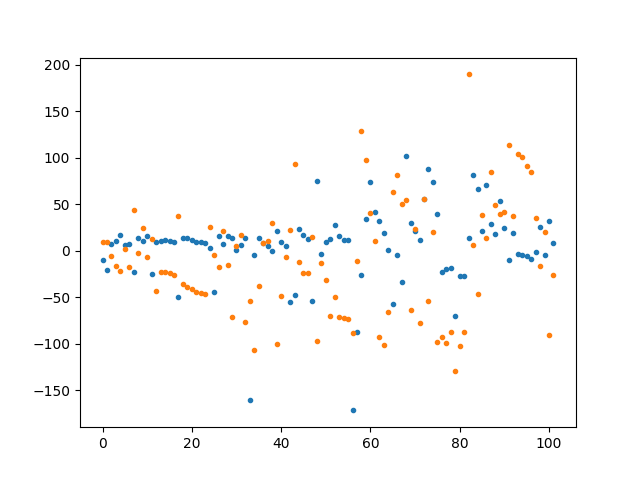

In [50]:
%matplotlib widget
import matplotlib.pyplot as plt

vxhist = [xx[-2] for xx in xxTimeHist]
vyhist = [xx[-1] for xx in xxTimeHist]

plt.plot(vxhist, '.')
plt.plot(vyhist, '.')